# Predicting demand likelihood on Avito's classified advertisements

* Score no Kaggle: 0.2489
* 7 features
* 6 intervalos de probabilidades, que devem ser ajustados 

In [1]:
import gc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn import preprocessing, utils
from sklearn.svm import SVC,SVR,LinearSVR
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression
from sklearn.externals import joblib

In [2]:
df_train = pd.read_csv('train.csv.zip', compression='zip')
#print(df_train.shape)
#df_train.head(2)

In [3]:
df_test= pd.read_csv('test.csv.zip', compression='zip')
#print(df_test.shape)
#df_test.head(2)

In [4]:
number_of_ads=df_train.shape[0]
#round(df_train.isnull().sum()*100/number_of_ads,2)

In [5]:
#Eliminar NaN nas colunas dos anúnicos. Aqui usamos apenas a coluna 'price'
#df_train_=df_train
#df_train_[['price']]=df_train_[['price']].fillna(0.0)
df_train['price'] = df_train['price'].replace(np.nan, 0.0, regex=True)
df_test['price'] = df_test['price'].replace(np.nan, 0.0, regex=True)
#round(df_train.isnull().sum()*100/number_of_ads,2)

## Explorando os dados 

#Regios e seus numeros de anúncios
region_ads_number= df_train['region'].value_counts()
#Guardar os nomes das regiões
regions_names = np.array(region_ads_number.index)
#Guardar os números de anuncios por região.
ads_numbers= np.array(region_ads_number)
#Criar um dataframe com as informações anterios
df_region_ads = pd.DataFrame({'region': regions_names, 'number of ads': ads_numbers})
rank = np.arange(0, len(df_region_ads))
plt.barh(rank, df_region_ads['number of ads'])
plt.yticks(rank, df_region_ads['region'])
plt.show()

In [210]:
#df_train[['category_name','price','deal_probability']].groupby('category_name').describe()
#df_train[['category_name','deal_probability']].groupby('category_name').describe()
#Probabilidade média por categoria
company_mean_grp=df_train[['category_name','deal_probability']].groupby('category_name').mean()

In [211]:
#Colocamos as categoria e suas probabilidades médias em um dicionário
dic_categories={}

for row in company_mean_grp.itertuples():
    #Formato ('category_name', deal_probability)
    str1=str(row[0]) 
    #Remover parenteses
    str2=str1.replace('(','')
    str3=str2.replace(')','')
    #Particionar em tokens separados por uma virgula: ,
    str4=str3.split(',')
    #Primeiro token é category_name
    category=str4[0]
    #Probabilidade é mais simples de extrair
    deal_probability=row.deal_probability
    #print(category, ' ',deal_probability) #Para teste
    dic_categories[category]=deal_probability
#dic_categories #Para teste

In [212]:
#Retorna a probabilidade média da categoria
def setCategoryProb(row):
    key=str(row['category_name'])
    prob=0.0
    if key in dic_categories.keys():
        prob=dic_categories[key]
    return prob

In [213]:
def setUserTypeProb(row):
    mean_prob=0.0
    user_type=str(row['user_type'])
    if user_type=="Shop":
        mean_prob=0.062829
    elif user_type=="Private":
        mean_prob=0.149557
    elif user_type=="Company":
        mean_prob=0.124513
    return mean_prob

In [214]:
def setUserTypeProp(row):
    prop=0.0
    user_type=str(row['user_type'])
    if user_type=="Shop":
        prop=0.053524
    elif user_type=="Private":
        prop=0.715504
    elif user_type=="Company":
        prop=0.230972
    return prop

In [215]:
#df_train['user_type_freq']=df_train.apply(setUserTypeProp, axis=1)
#df_train['user_type_prob']=df_train.apply(setUserTypeProb, axis=1)
#df_train[['user_type','user_type_freq', 'user_type_prob']].head(12) #Para teste

In [216]:
#Histograma preços
#df_train['price'].describe()

In [217]:
#Faixas
#Qualidade alta
df_train_price_EH=df_train.query("price>2.987259e+05")
df_train_price_VH=df_train.query("price>6000.0 and price<=2.987259e+05")
df_train_price_H=df_train.query("price>1000 and price<=6000") 
#Qualidade Media 
df_train_price_M=df_train.query("price>400 and price<=1000")
df_train_price_VM=df_train.query("price>300 and price<=400") 
#Qualidade Baixa 
df_train_price_L=df_train.query("price>200 and price<=300")
df_train_price_VL=df_train.query("price<100 and price<=200")
df_train_price_EL=df_train.query("price<=100")
#print('EH:', df_train_price_EH.shape[0] )
#print('VH:', df_train_price_VH.shape[0] )
#print('H:', df_train_price_H.shape[0] )
#print('M:', df_train_price_M.shape[0] )
#print('VM:', df_train_price_VM.shape[0] )
#print('L:', df_train_price_L.shape[0] )
#print('VL:', df_train_price_VL.shape[0] )
#print('EL:', df_train_price_EL.shape[0] )

In [218]:
mean_EH=df_train_price_EH['deal_probability'].mean()
mean_VH=df_train_price_VH['deal_probability'].mean()
mean_H=df_train_price_H['deal_probability'].mean()
mean_M=df_train_price_M['deal_probability'].mean()
mean_VM=df_train_price_VM['deal_probability'].mean()
mean_L=df_train_price_L['deal_probability'].mean()
mean_VL=df_train_price_VL['deal_probability'].mean()
mean_EL=df_train_price_EL['deal_probability'].mean()

#print('\n',mean_EH,'\n', mean_VH,'\n', mean_H,'\n', mean_M,'\n', mean_VM,
#      '\n', mean_L,'\n', mean_VL,'\n', mean_EL)

In [219]:
def setPriceRangeProba(row):
    proba=0.0
    price=row['price']
    if price>2.987259e+05:
        proba=mean_EH
    elif price>6000.0 and price<=2.987259e+05:
        proba=mean_VH
    elif price>1000 and price<=6000.0:
        proba=mean_H
    elif price>400 and price<=1000:
        proba=mean_M
    elif price>300 and price<=400:
        proba=mean_VM
    elif price>200 and price<=300:
        proba=mean_L
    elif price<100 and price<=200:
        proba=mean_VL
    elif price<=100:
        proba=mean_EL
    return proba

In [220]:
#df_train['priceRangeProbability'] = df_train.apply(setPriceRangeProba, axis=1)
#df_train[['price','priceRangeProbability']].head() para teste

#Reputaçao do anunciante

In [221]:
#df_train[['user_id']].describe()

In [222]:
grp_user= df_train[['user_id','deal_probability']].groupby('user_id').mean()
#grp_user.describe()

In [223]:
#Colocamos os anunciantes(user_id) e suas probabilidades médias em um dicionário
dic_user_proba={}

for row in grp_user.itertuples():
    #Formato ('user_id', deal_probability)
    str1=str(row[0]) 
    #Remover parenteses
    str2=str1.replace('(','')
    str3=str2.replace(')','')
    #Particionar em tokens separados por uma virgula: ,
    str4=str3.split(',')
    #Primeiro token é user_id
    user_id=str4[0]
    #Probabilidade é mais simples de extrair
    dic_user_proba[user_id]=row.deal_probability


In [224]:
#Retorna a probabilidade média do user
def setUserProba(row):
    key=str(row['user_id'])
    #Se for o primeiro a anuncio do usuario: a probabilidade é 0.5
    prob=0.0
    if key in dic_user_proba.keys():
        prob=dic_user_proba[key]
    return prob

### Features set up (apply function on DataFrame)
> Pode configurar todos os apply uma única vez aqui para facilitar os testes. Alem de aplicao ao train e test ao mesmo tempo.

Histograma das probabilidades

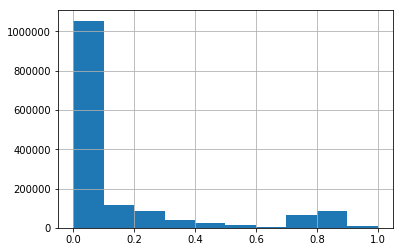

In [225]:
df_train['deal_probability'].hist()

Categorizar as probabilidades

In [226]:
#Categorias
df_train_P1=df_train.query("deal_probability>=0.70") 
df_train_P2=df_train.query("deal_probability>=0.60 and deal_probability<0.70")
df_train_P3=df_train.query("deal_probability>=0.50 and deal_probability<0.60") 
df_train_P4=df_train.query("deal_probability>=0.40 and deal_probability<0.50") 
df_train_P5=df_train.query("deal_probability>=0.25 and deal_probability<0.4") 
df_train_P6=df_train.query("deal_probability<0.25") 

print('Qde de rows Qualidade P1..:', df_train_P1.shape[0])
print('Qde de rows Qualidade P2..:', df_train_P2.shape[0])
print('Qde de rows Qualidade P3..:', df_train_P3.shape[0])
print('Qde de rows Qualidade P4..:', df_train_P4.shape[0])
print('Qde de rows Qualidade P5..:', df_train_P5.shape[0])
print('Qde de rows Qualidade P6..:', df_train_P6.shape[0])

number_of_ads==df_train_P1.shape[0]+df_train_P2.shape[0]+df_train_P3.shape[0]\
            +df_train_P4.shape[0]+ df_train_P5.shape[0]+ df_train_P6.shape[0]

Qde de rows Qualidade P1..: 163045
Qde de rows Qualidade P2..: 9799
Qde de rows Qualidade P3..: 9169
Qde de rows Qualidade P4..: 21969
Qde de rows Qualidade P5..: 79001
Qde de rows Qualidade P6..: 1220441


True

In [227]:
perc_P1=len(df_train_P1.index)/number_of_ads
perc_P2=len(df_train_P2.index)/number_of_ads
perc_P3=len(df_train_P3.index)/number_of_ads
perc_P4=len(df_train_P4.index)/number_of_ads
perc_P5=len(df_train_P5.index)/number_of_ads
perc_P6=len(df_train_P6.index)/number_of_ads
print(perc_P1, '-',perc_P2,'-', perc_P3,'-', perc_P4, '-',perc_P5, '-',perc_P6)

0.10844911349027286 - 0.006517788727597803 - 0.006098745264143715 - 0.014612644204163297 - 0.05254738516878805 - 0.8117743231450343


Extraction of 60.000 rows for trains and 20000 for tests

In [228]:
sample_size=60000
train_sample_size=int(sample_size * 0.67)
test_sample_size=sample_size-train_sample_size

P1_sample_size=int(perc_P1*sample_size)
P2_sample_size=int(perc_P2*sample_size)
P3_sample_size=int(perc_P3*sample_size)
P4_sample_size=int(perc_P4*sample_size)
P5_sample_size=int(perc_P5*sample_size)
P6_sample_size=sample_size-(P1_sample_size+P2_sample_size+P3_sample_size+P4_sample_size+P5_sample_size)
print('P1 size:', P1_sample_size, '- P2 size: ', P2_sample_size, '- P3 size : ',P3_sample_size, 
      '- P4 size : ',P4_sample_size, '- P5 size : ',P5_sample_size, 
      '- P6 size : ', P6_sample_size)

P1 size: 6506 - P2 size:  391 - P3 size :  365 - P4 size :  876 - P5 size :  3152 - P6 size :  48710


In [229]:
#Extrair amostra de cada categoria
df_P1=df_train_P1.sample(n=P1_sample_size, random_state=random.randint(1,P1_sample_size))
df_P2=df_train_P2.sample(n=P2_sample_size, random_state=random.randint(1,P2_sample_size))
df_P3=df_train_P3.sample(n=P3_sample_size, random_state=random.randint(1,P3_sample_size))
df_P4=df_train_P4.sample(n=P4_sample_size, random_state=random.randint(1,P4_sample_size))
df_P5=df_train_P5.sample(n=P5_sample_size, random_state=random.randint(1,P5_sample_size))
df_P6=df_train_P6.sample(n=P6_sample_size, random_state=random.randint(1,P6_sample_size))
print('P1: ', df_P1.shape, 'P2: ', df_P2.shape,' P3:', df_P3.shape,' P4:', df_P4.shape,
      ' P5:', df_P5.shape, ' P6:', df_P6.shape)

P1:  (6506, 18) P2:  (391, 18)  P3: (365, 18)  P4: (876, 18)  P5: (3152, 18)  P6: (48710, 18)


Unir os conjunto de anúncios em df

In [230]:
#5 categorias
df_sample=pd.concat([df_P1, df_P2, df_P3, df_P4, df_P5, df_P6], axis=0)
print('sample size and test size :', df_sample.shape)

sample size and test size : (60000, 18)


#### Features extraction
Only numeric data

In [231]:
#Funções auxiliadora que se aplicam a qualquer caso: city,region etc
def groupByEntityMeanAttr(entity, attribute='deal_probability'):
    return df_train[[entity,attribute]].groupby(entity).mean()

def getDictEntityMeanByGrp(grp_entity):
    dic_entity_proba={}
    for row in grp_entity.itertuples():
        #Exemplo: Formato ('entity', deal_probability)
        str1=str(row[0]) 
        #Remover parenteses
        str2=str1.replace('(','')
        str3=str2.replace(')','')
        #Particionar em tokens separados por uma virgula: ,
        str4=str3.split(',')
        #Primeiro token é entity
        entity=str4[0]
        
        #Probabilidade é mais simples de extrair
        #dic_entity_proba[entity]=row.deal_probability
        #Probabilidade é mais simples de extrair
        attribute_value=row[1]
        dic_entity_proba[entity]=attribute_value
    return dic_entity_proba

#Retorna a probabilidade média do user
def setCityPrice(row,attribute):
    key=str(row['city'])
    meanPrice=0.0
    if key in dic_city_meanPrice.keys():
        meanPrice=dic_city_meanPrice[key]
    return meanPrice

def setCityProba(row):
    #key=str(row['attribute'])
    key=str(row['city'])
    prob=0.0
    if key in dic_city_meanPrice.keys():
        prob=dic_city_meanPrice[key]
    return prob

def setEntityProba(row,entity='o', dic_entity=None):
    key=str(row[entity])
    prob=0.0
    if key in dic_entity.keys():
        prob=dic_entity[key]
    return prob

def setEntityPrice(row,entity='o', dic_entity=None):
    key=str(row[entity])
    price=0.0
    if key in dic_entity.keys():
        price=dic_entity[key]
    return price

def setEntityCondProba(row,entity_1=None, entity_2=None):
    return row[entity_1]*row[entity_2]

In [232]:
#Testes
grp_city_meanPrice=groupByEntityMeanAttr('city', attribute='price')
dic_city_meanPrice=getDictEntityMeanByGrp(grp_city_meanPrice)
#grp_city_MeanPrice.describe()

grp_city_meanProba=groupByEntityMeanAttr('city')
dic_city_meanProba=getDictEntityMeanByGrp(grp_city_meanProba)
#grp_city_MeanProba.describe()


grp_region_meanProba=groupByEntityMeanAttr('region')
dic_region_meanProba=getDictEntityMeanByGrp(grp_region_meanProba)
#grp_region_MeanPrice.describe()

grp_prtCategory_meanProba=groupByEntityMeanAttr('parent_category_name')
dic_prtCategory_meanProba=getDictEntityMeanByGrp(grp_prtCategory_meanProba)
#grp_prtCategory_MeanProba.describe()

In [233]:
#For train
df_sample['category_prob']=df_sample.apply(setCategoryProb, axis=1)
df_sample['user_type_freq']=df_sample.apply(setUserTypeProp, axis=1)
df_sample['user_type_prob']=df_sample.apply(setUserTypeProb, axis=1)

df_sample['user_type_condProb']=df_sample.apply(setEntityCondProba,  entity_1='user_type_freq',\
                                                entity_2='user_type_prob',axis=1)

df_sample['priceRangeProbability'] = df_sample.apply(setPriceRangeProba, axis=1)

df_sample['city_probability'] = df_sample.apply(setEntityProba, entity='city', 
                                              dic_entity=dic_city_meanProba, axis=1)

df_sample['city_price'] = df_sample.apply(setEntityPrice, entity='city', 
                                              dic_entity=dic_city_meanPrice, axis=1)

df_sample['region_probability'] = df_sample.apply(setEntityProba, entity='region', 
                                              dic_entity=dic_region_meanProba, axis=1)

df_sample['prt_category_probability'] = df_sample.apply(setEntityProba, entity='parent_category_name', 
                                              dic_entity=dic_prtCategory_meanProba, axis=1)

In [234]:
#For Submission
df_test['category_prob']=df_test.apply(setCategoryProb, axis=1)
df_test['user_type_freq']=df_test.apply(setUserTypeProp, axis=1)
df_test['user_type_prob']=df_test.apply(setUserTypeProb, axis=1)
df_test['user_type_condProb']=df_test.apply(setEntityCondProba,  entity_1='user_type_freq',\
                                                entity_2='user_type_prob',axis=1)

df_test['priceRangeProbability'] = df_test.apply(setPriceRangeProba, axis=1)


df_test['city_probability'] = df_test.apply(setEntityProba, entity='city', 
                                              dic_entity=dic_city_meanProba, axis=1)
df_test['city_price'] = df_test.apply(setEntityPrice, entity='city', 
                                              dic_entity=dic_city_meanPrice, axis=1)

df_test['region_probability'] = df_test.apply(setEntityProba, entity='region', 
                                              dic_entity=dic_region_meanProba, axis=1)

df_test['prt_category_probability'] = df_test.apply(setEntityProba, entity='parent_category_name', 
                                              dic_entity=dic_prtCategory_meanProba, axis=1)


In [235]:
#Teste

df_sample[['user_type_freq', 'user_type_prob', 'user_type_condProb', 'category_prob', 
           'priceRangeProbability','price','city_price','city_probability','region_probability',
           'prt_category_probability', 'deal_probability']].head(2)


,user_type_freq,user_type_prob,user_type_condProb,category_prob,priceRangeProbability,price,city_price,city_probability,region_probability,deal_probability
1294223,0.715504,0.149557,0.107009,0.403123,0.197847,0.0,213772.260071,0.158694,0.124193,0.80000
581771,0.715504,0.149557,0.107009,0.000000,0.154089,3800.0,237922.073887,0.139400,0.136721,0.80323


In [236]:
#USO DE TODAS AS FEATURES
"""
X=df_sample[['user_type_freq', 'user_type_prob', 'user_type_condProb','category_prob','user_type_condProb', 'price', 'city_price',
             'priceRangeProbability','city_probability','region_probability',
             'prt_category_probability']].values
#para submission
X_submission=df_test[['user_type_freq', 'user_type_prob', 'user_type_condProb','category_prob', 'price', 
             'priceRangeProbability','city_probability','region_probability',
                      'prt_category_probability']].values
"""
#USO DE ALGUMAS FEATURES
##7features
X=df_sample[['user_type_condProb', 'category_prob', 'price', 'city_price',
             'priceRangeProbability','city_probability','region_probability'\
            ]].values
#para submission
X_submission=df_test[['user_type_condProb', 'category_prob', 'price', 'city_price',
             'priceRangeProbability','city_probability','region_probability'\
                    ]].values

print(X.shape,X_submission.shape)

(60000, 7) (508438, 7)


In [237]:
y=df_sample['deal_probability'].values 
y.shape

(60000,)

Extraimos parte das features e target para o treinamento. E outra parte para os testes

In [238]:
#Embaralhar, antes de selecionar
seed_=random.randint(1,sample_size)
np.random.seed(seed_)
np.random.shuffle(X)

np.random.seed(seed_)
np.random.shuffle(y)

n=train_sample_size 
#features and targets for trains
X_train=X[:n]
y_train=y[:n]
#features and targets for tests
X_test=X[n:]
y_test=y[n:]

In [239]:
#Liberar memoria
del dic_user_proba, dic_categories, company_mean_grp
del grp_city_meanProba, grp_city_meanPrice, grp_region_meanProba, grp_prtCategory_meanProba
del dic_city_meanProba, dic_city_meanPrice, dic_region_meanProba, dic_prtCategory_meanProba
gc.collect()

569

In [240]:
#del df_train_P1, df_train_P2, df_train_P3, df_train_P4, df_train_P5
del perc_P1, perc_P2, perc_P3, perc_P4, perc_P5
del df_P1,df_P2, df_P3,df_P4, df_P5 
del perc_P6, df_P6
gc.collect()

0

### 1. Previsão usando regressão com SVR

In [241]:
gc.collect()

0

In [242]:
#Instanciar e treinar
clf=None
#clf = joblib.load('lregV06_7feats_26_01.pkl') 
clf = LinearRegression()
clf.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [243]:
#prever
y_hat=clf.predict(X_test)
print('y_hat........:', y_hat[:5])
print('y_test.......:',y_test[:5])

y_hat........: [0.0550291  0.2092595  0.34469688 0.08275404 0.36580469]
y_test.......: [0.12579 0.      0.2     0.      0.     ]


Vamos calcular o erro da previsão com variancia e desvio padrão.

In [244]:
#Função auxiliar usada para avaliar as técnicas
#Calcular a variancia de qualquer probalidade estimada
def setVariance(row):
    """
    Entrada:
        row:tupla de dataframe
    Saída:
        variancia:float
    """
    return (row['predicted_deal_probality']-row['expected_deal_probality'])**2

* Criar dataframe com as demandas/probabilidades previstas e as estimadas pelo classificador
* Aplicar a função em cada tupla para obter a variancia da probabilidade estimada.
* calcular a variancia e desvio padrão considerando a media da amostra. 
* Desvio está baixo?

In [245]:
#AVALIAR
df_proba = pd.DataFrame({'expected_deal_probality': y_test,
                         'predicted_deal_probality': y_hat})
#Cria-se uma nova coluna no df
df_proba['desvio'] = df_proba.apply(setVariance, axis=1)
std=np.sqrt(df_proba[['desvio']].sum()/len(df_proba.index))
print('Desvio baixo? ', std)
df_proba.head()

Desvio baixo?  desvio    0.241638
dtype: float64


,expected_deal_probality,predicted_deal_probality,desvio
0,0.12579,0.055029,0.005007
1,0.00000,0.209259,0.043790
2,0.20000,0.344697,0.020937
3,0.00000,0.082754,0.006848
4,0.00000,0.365805,0.133813


In [246]:
#Limpar a memoria do treino

### Prever com base em teste (df_test)

In [247]:
# A extração das features das submissions foi feita no mesmo tempo das do treino

In [248]:
#Verificar o tamanho matriz
print(X_submission.shape)

(508438, 7)


In [249]:
#Prever as probabilidades
y_submission=clf.predict(X_submission)
print(y_submission.shape)

(508438,)


In [250]:
#Pode haver valores fora do dominio: probabilidade<0.0 ou > 1.0

y_list=list(y_submission)
y_list2=[]

for i in range(0,len(y_list)):
    proba=y_list[i]
    if proba<0.0:
        y_list2.append(0.0)
    elif proba>1.0:
        y_list2.append(1.0)
    else:
        y_list2.append(proba)
#Novo array de y
y_submission_=np.array(y_list2)
len(y_submission_)

508438

In [251]:
df_submission= pd.DataFrame(
    {'deal_probability': y_submission_}, 
    index=df_test['item_id'])
#sub_7feat_26_alg2V06_2 Teve desvio de 0,2416
df_submission.to_csv('sub_7feat_26_alg2V06_2.csv')
df_submission.head()

,deal_probability
item_id,
6544e41a8817,0.109296
65b9484d670f,0.239742
8bab230b2ecd,0.192901
8e348601fefc,0.264271
8bd2fe400b89,0.253230


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000F49A41B4A8>]],
      dtype=object)

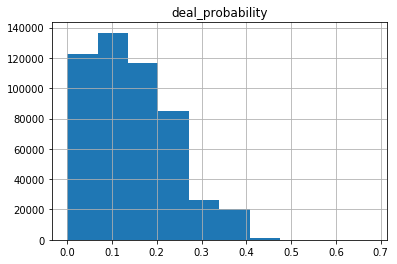

In [46]:
df_submission.hist()

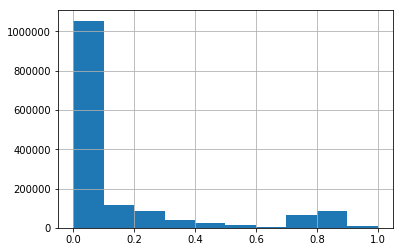

In [47]:
df_train['deal_probability'].hist()

In [49]:
df_submission.describe()

,deal_probability
count,508438.000000
mean,0.145158
std,0.091864
min,0.000000
25%,0.071373
50%,0.132456
75%,0.206156
max,0.679359


In [50]:
train=df_train[['deal_probability']]
train.describe()

,deal_probability
count,1.503424e+06
mean,1.391306e-01
std,2.600785e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,1.508700e-01
max,1.000000e+00


In [51]:
joblib.dump(clf, 'lregV06_7feats_26_01.pkl')
#clf_loaded = joblib.load('svr05_26_13h42.pkl') 

['lregV06_7feats_26_01.pkl']

In [56]:
#import pickle
#s = pickle.dumps(clf)
#clf2 = pickle.loads(s) 

In [57]:
X.shape[0]

60000

In [59]:
df_train.shape[0]

1503424

In [ ]:
y_hat_encoded.shape

In [97]:
def predict(X_, clf_ ):
    #print(df.head())
    #print(X_)
    return clf_.predict(X_)
    
def performPrediction(X_submission_,clf_, number=25000):
    X_submission_list=[]
    min=0
    max=number
    add=number
    
    for i in range(0,20):
        X_submission_list.append(X_submission_[min:max])
        #print('min=',min,'max=', max)
        min+=add
        max+=add
        
    
    max=X_submission_.shape[0]
    #print(min, max)
    if min!=max:
        X_submission_list.append(X_submission_[min:])
        
    #print(len(X_submission_list))
    
    y_hat_encoded_parts=[]
    for i in range(0,len(X_submission_list)):
        y_hat_encoded_parts.append(pd.Series(predict(X_submission_list[i],clf_)))
    
    y_hat_encoded=pd.concat((y_hat_encoded_parts[0],y_hat_encoded_parts[1],y_hat_encoded_parts[2],\
                        y_hat_encoded_parts[3],y_hat_encoded_parts[4],y_hat_encoded_parts[5],\
                        y_hat_encoded_parts[6],y_hat_encoded_parts[7],y_hat_encoded_parts[8],\
                        y_hat_encoded_parts[9],y_hat_encoded_parts[10],y_hat_encoded_parts[11],\
                        y_hat_encoded_parts[12],y_hat_encoded_parts[13],y_hat_encoded_parts[14],\
                        y_hat_encoded_parts[15],y_hat_encoded_parts[16],y_hat_encoded_parts[17],\
                        y_hat_encoded_parts[18],y_hat_encoded_parts[19],y_hat_encoded_parts[20],\
                             ),axis=0)
    return y_hat_encoded.values

In [45]:
#clf_loaded = joblib.load('svr05_26_13h42.pkl')
clf_loaded

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [98]:
y_=performPrediction(X_test,clf_loaded, number=600)